In [1]:
import os

import cv2 as cv
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from mplsoccer import Pitch
from tqdm.auto import tqdm
from matplotlib import cm


In [2]:
def get_xsys(filepath): 
    df = pd.read_csv(filepath).drop(0)

    H = np.array([
        [ 7.69300719e+01, -6.91177136e+02,  1.41744644e+04],
        [-5.61279889e+02, -9.35972045e+01,  8.20184399e+04],
        [-5.57301063e-03, -6.24508918e-03,  1.00000000e+00]])

    _xsys = np.expand_dims(df[['Lon', 'Lat']].values, axis=0)
    xsys = cv.perspectiveTransform(_xsys, H)
    
    # transpose to get (xs) and (ys)
    return xsys.T.squeeze()

In [3]:
def trajectory_square(plot_num):
    '''plot coruse trajectory
    Args:
        xc: x coordinate of course
        yc: y coordinate of course
        plot_num: number of plot

    Return 

    '''
    
    xc = np.array([16.5,16.5,45.4,45.4,43.35])
    yc = np.array([13.84,54.16,13.84,54.16,34])

    #スクエアの縦横の長さの比を算出
    vertical_length_ratio = (yc[1]-yc[0])/((xc[2]-xc[0])+(yc[1]-yc[0]))
    horizon_length_ratio = (xc[2]-xc[0])/((xc[2]-xc[0])+(yc[1]-yc[0]))

    line_v = int(plot_num * vertical_length_ratio)
    line_h = int(plot_num * horizon_length_ratio)

    #スクエアのプロットの座標を算出
    right_line_x = np.linspace(xc[2], xc[2],int(line_v/2))
    right_line_y = np.linspace(yc[0], yc[1],int(line_v/2))
    up_line_x = np.linspace(xc[0], xc[2],int(line_h/2))
    up_line_y = np.linspace(yc[0], yc[0],int(line_h/2))
    left_line_x = np.linspace(xc[0], xc[0],int(line_v/2))
    left_line_y = np.linspace(yc[0], yc[1],int(line_v/2))
    buttom_line_x = np.linspace(xc[0], xc[2],int(line_h/2))
    buttom_line_y = np.linspace(yc[1], yc[1],int(line_h/2))

    xc_s = np.concatenate((right_line_x, up_line_x,left_line_x,buttom_line_x), axis = 0)
    yc_s = np.concatenate((right_line_y, up_line_y,left_line_y,buttom_line_y), axis = 0)
    return np.vstack((xc_s, yc_s))

In [4]:
def trajectory_circle(plot_num):
    '''plot coruse trajectory(circle)
    Args:
        plot_num: number of plot

    Returns:
        xc_c: array of x coordinate of circle
        yc_c: array of y coordinate of circle
    '''
    theta = np.linspace(0, 2*np.pi, plot_num)
    radius = 9.15
    xc_c = radius*np.cos(theta) + 52.5
    yc_c = radius*np.sin(theta) + 34
    return np.vstack((xc_c, yc_c)) 


In [5]:
def shape_to_shape_distance(shape1, shape2):
    assert len(shape1) == 2
    assert len(shape2) == 2
    
    n_points = len(shape1.T)

    point_to_point_distance = (np.repeat(np.expand_dims(shape2.T, 0), n_points, 0) - np.expand_dims(shape1.T, 1))
    point_to_point_euclidean = np.linalg.norm(point_to_point_distance, axis=-1)
    point_to_shape_distance = np.min(point_to_point_euclidean, axis=-1)
    shape_to_shape_distance = point_to_shape_distance.mean()
    return shape_to_shape_distance

In [6]:
def process_path(path):
    basename = os.path.basename(path)
    date, person, _, _, course, speed = os.path.splitext(basename)[0].split('_') 
    return person, course, speed

In [7]:
from tqdm.auto import tqdm

N = 1000
sq_xs, sq_ys = sq_xsys = trajectory_square(N)
cl_xs, cl_ys = cl_xsys = trajectory_circle(N)

data_dict = {}
paths = glob('./GPS_data/*/*.csv')
for filepath in paths:
    person, course, speed = process_path(filepath)
    xs, ys = xsys = get_xsys(filepath)
    if course.lower() != 'zigzag':
        data_dict[(person, course, speed)] = xsys

def base_fun(x_offset, y_offset, return_distances=False):
    distances = []
    for (person, course, speed), xsys in data_dict.items():    
        xsys = xsys.copy() + np.array([[x_offset, y_offset]]).T
        
        if course.lower() == 'square':
            dist = shape_to_shape_distance(xsys, sq_xsys)
        elif course.lower() == 'circle':
            dist = shape_to_shape_distance(xsys, cl_xsys)
        else:
            raise Exception('course is not square or circle')
        distances.append(dist)
    if return_distances:
        return distances
    return np.mean(distances)

x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
dist_grid = np.zeros((len(x_range), len(y_range)))

for xi, x_offset in enumerate(tqdm(x_range)):
    for yi, y_offset in enumerate(y_range):
        dist_grid[yi, xi] = base_fun(x_offset, y_offset)

100%|██████████| 100/100 [35:37<00:00, 21.37s/it]


Text(0.5, 0, 'mean_error_distance')

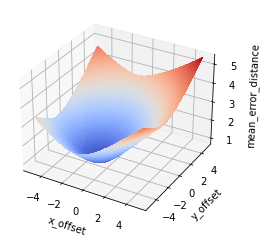

In [19]:
X, Y = np.meshgrid(y_range, x_range)
Z = dist_grid
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("x_offset")
ax.set_ylabel("y_offset")
ax.set_zlabel("mean_error_distance")

In [22]:
y_idx, x_idx = np.unravel_index(dist_grid.argmin(), dist_grid.shape)
x_offset, y_offset = x_range[x_idx], y_range[y_idx]
distances = base_fun(x_offset, y_offset, return_distances=True)
print(f"x_offset: {x_offset}, y_offset: {y_offset}, mean distance: {np.mean(distances)}")

for distance, ((person, course, speed), xsys) in zip(distances, data_dict.items()):
    #ピッチ座標を可視化
    pitch = Pitch(
        pitch_color="black",
        line_color=(0.3, 0.3, 0.3),
        pitch_type="custom",
        pitch_length=105,
        pitch_width=68,
    )

    #circle sessionの正規コース
    circle = patches.Circle(
        xy=(52.5, 34), 
        radius=9.15, 
        edgecolor='darkorange', 
        fill=False
        )

    fig, ax = pitch.draw()
    ax.add_patch(circle)
    ax.scatter(*xsys, color="red", s=1)
    ax.scatter(sq_xs, sq_ys, color="darkorange",s=1)
    ax.set_title(f"{person}_{course}_{speed}, Distance={distance:.2f}")
    plt.savefig(f"./GPS_output/{person}_{course}_{speed}.png")
    plt.close()

x_offset: -1.0606060606060606, y_offset: -1.4646464646464645, mean distance: 0.7606237808991627
